# Stage 08: Exploratory Data Analysis

### Imports and getting secrets from `.env`

In [23]:
import plotly.graph_objects as go
import time
from SmartApi import SmartConnect
from pyotp import TOTP
from datetime import datetime
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv("../.env")

api_key = os.getenv("api_key")
client_code = os.getenv("client_code")
pwd = os.getenv("pwd")
totp = os.getenv("totp")

### Connection with API

In [6]:
obj = SmartConnect(api_key=api_key)
session = obj.generateSession(client_code, pwd, TOTP(totp).now())
refreshToken = session['data']['refreshToken']
authToken = session['data']['jwtToken']
feedToken = obj.getfeedToken()
res = obj.getProfile(refreshToken)
obj.generateToken(refreshToken)

[I 250823 17:37:38 smartConnect:124] in pool


{'status': True,
 'message': 'SUCCESS',
 'errorcode': '',
 'data': {'jwtToken': 'eyJhbGciOiJIUzUxMiJ9.eyJ1c2VybmFtZSI6IkQ1MzEwMzQiLCJyb2xlcyI6MCwidXNlcnR5cGUiOiJVU0VSIiwidG9rZW4iOiJleUpoYkdjaU9pSlNVekkxTmlJc0luUjVjQ0k2SWtwWFZDSjkuZXlKMWMyVnlYM1I1Y0dVaU9pSmpiR2xsYm5RaUxDSjBiMnRsYmw5MGVYQmxJam9pZEhKaFpHVmZZV05qWlhOelgzUnZhMlZ1SWl3aVoyMWZhV1FpT2pFeUxDSnpiM1Z5WTJVaU9pSXpJaXdpWkdWMmFXTmxYMmxrSWpvaVlUSTNabU0wTW1ZdE5Ea3lOQzB6TjJKbExUaGtNR0l0TlRZM1lXUTROR0ZoWXpVd0lpd2lhMmxrSWpvaWRISmhaR1ZmYTJWNVgzWXlJaXdpYjIxdVpXMWhibUZuWlhKcFpDSTZNVElzSW5CeWIyUjFZM1J6SWpwN0ltUmxiV0YwSWpwN0luTjBZWFIxY3lJNkltRmpkR2wyWlNKOUxDSnRaaUk2ZXlKemRHRjBkWE1pT2lKaFkzUnBkbVVpZlgwc0ltbHpjeUk2SW5SeVlXUmxYMnh2WjJsdVgzTmxjblpwWTJVaUxDSnpkV0lpT2lKRU5UTXhNRE0wSWl3aVpYaHdJam94TnpVMk1EY3hORFU0TENKdVltWWlPakUzTlRVNU9EUTROemdzSW1saGRDSTZNVGMxTlRrNE5EZzNPQ3dpYW5ScElqb2lNakkyTWpSbU1qQXRaR00xTWkwMFpqQTFMV0poTnpFdE5HWmxNR1V6Wm1OaU9UZzNJaXdpVkc5clpXNGlPaUlpZlEuVjBISERlRS1zTU9qUEdrOW42QnJtR1Q2NUhTRFNRRWJ2UkxNMERmU0RRQWdYYktTOWlhVG4zaTZUMX

### Loading and Cleaning Data

In [15]:
expirydate_l = ["02SEP2025", "09SEP2025"]
ce_df = pd.DataFrame()
pe_df = pd.DataFrame()

# Try to Fetch Greeks Live and save or run saved data
try:
    for expirydate in expirydate_l:
        time.sleep(1)  # Rate limits
        greek_params = {"name": "NIFTY", "expirydate": expirydate}
        greek_res = obj.optionGreek(greek_params)
        greek_df = pd.DataFrame(greek_res['data'])
    
        ce_df = pd.concat([ce_df, greek_df[greek_df['optionType'] == "CE"]], ignore_index=True)
        pe_df = pd.concat([pe_df, greek_df[greek_df['optionType'] == "PE"]], ignore_index=True)
        ce_df.to_csv("data/ce_df.csv")
        pe_df.to_csv("data/pe_df.csv")

except Exception as e:
    print("Live API not working... Continuing with saved data")
    ce_df = pd.read_csv("../data/ce_df.csv")
    pe_df = pd.read_csv("../data/pe_df.csv")
    ce_df = ce_df.drop(columns=ce_df.filter(like="Unnamed").columns)
    pe_df = pe_df.drop(columns=pe_df.filter(like="Unnamed").columns)

# Clean and process
for df in [ce_df, pe_df]:
    df['impliedVolatility'] = pd.to_numeric(df['impliedVolatility'], errors='coerce')
    df.dropna(subset=['impliedVolatility'], inplace=True)
    df = df[df['impliedVolatility'] > 0]

# DTE Calculation
today = datetime.today()
ce_df['dte'] = ce_df['expiry'].apply(lambda x: (datetime.strptime(x, "%d%b%Y") - today).days)
pe_df['dte'] = pe_df['expiry'].apply(lambda x: (datetime.strptime(x, "%d%b%Y") - today).days)

[E 250823 17:41:29 smartConnect:246] Error occurred while making a POST request to https://apiconnect.angelone.in/rest/secure/angelbroking/marketData/v1/optionGreek. Error: No Data Available. URL: https://apiconnect.angelone.in/rest/secure/angelbroking/marketData/v1/optionGreek, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '10:5b:ad:07:c9:4a', 'Accept': 'application/json', 'X-PrivateKey': 'q3NHa6rL', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'name': 'NIFTY', 'expirydate': '02SEP2025'}, Response: {'status': False, 'message': 'No Data Available', 'errorcode': 'AB9019', 'data': None}


Live API not working... Continuing with saved data


In [16]:
ce_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               280 non-null    object 
 1   expiry             280 non-null    object 
 2   strikePrice        280 non-null    float64
 3   optionType         280 non-null    object 
 4   delta              280 non-null    float64
 5   gamma              280 non-null    float64
 6   theta              280 non-null    float64
 7   vega               280 non-null    float64
 8   impliedVolatility  280 non-null    float64
 9   tradeVolume        280 non-null    float64
 10  dte                280 non-null    int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 24.2+ KB


In [17]:
ce_df.describe()

,strikePrice,delta,gamma,theta,vega,impliedVolatility,tradeVolume,dte
count,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,2.800000e+02,280.000000
mean,24960.535714,0.508130,0.000227,-15.233844,9.907006,17.851036,1.093125e+05,9.507143
std,1202.888429,0.346556,0.000165,8.698867,7.287486,8.754566,4.086453e+05,5.848134
min,22600.000000,0.000300,0.000000,-40.915300,0.018300,0.000000,1.000000e+00,2.000000
25%,24000.000000,0.168500,0.000100,-19.588200,3.287350,11.630000,1.800000e+01,2.000000
50%,24950.000000,0.515200,0.000200,-15.159650,8.791300,14.815000,5.155000e+02,9.000000
75%,25950.000000,0.856700,0.000300,-9.095750,15.876700,21.070000,1.632600e+04,14.000000
max,27400.000000,0.999800,0.000700,-0.093000,24.370800,59.460000,4.201164e+06,21.000000


### No nan values

In [18]:
print("Missing values:\n", ce_df.isna().sum())

Missing values:
 name                 0
expiry               0
strikePrice          0
optionType           0
delta                0
gamma                0
theta                0
vega                 0
impliedVolatility    0
tradeVolume          0
dte                  0
dtype: int64


### Basic Statistical Plots

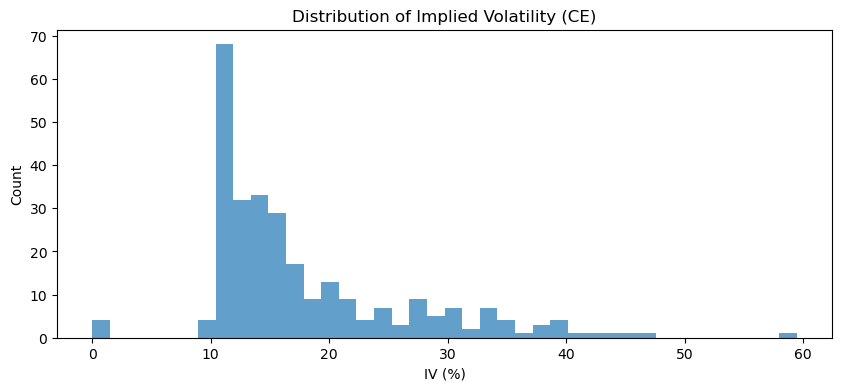

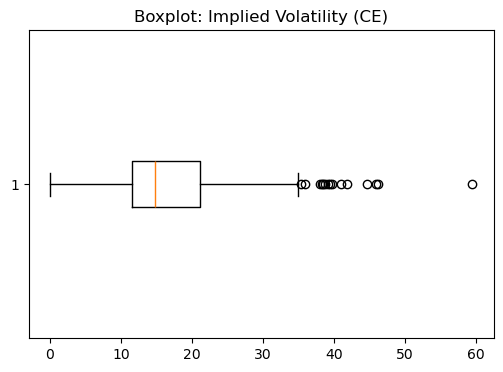

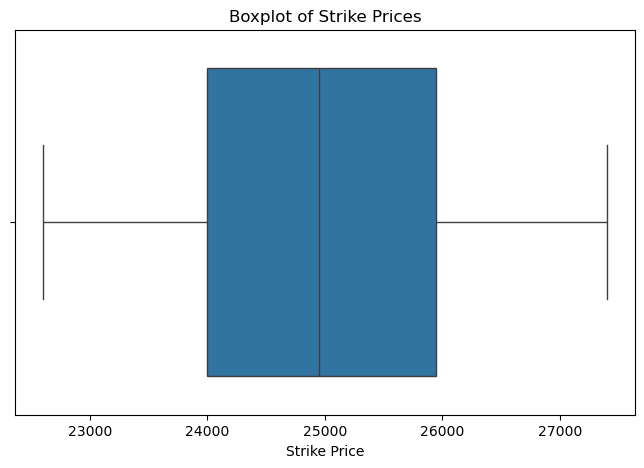

In [27]:
plt.figure(figsize=(10,4))
plt.hist(ce_df['impliedVolatility'], bins=40, alpha=0.7)
plt.title("Distribution of Implied Volatility (CE)")
plt.xlabel("IV (%)")
plt.ylabel("Count")
plt.show();

plt.figure(figsize=(6,4))
plt.boxplot(ce_df['impliedVolatility'], vert=False)
plt.title("Boxplot: Implied Volatility (CE)")
plt.show();

plt.figure(figsize=(8, 5))
sns.boxplot(x=ce_df["strikePrice"])
plt.title("Boxplot of Strike Prices")
plt.xlabel("Strike Price")
plt.show();

### Correlation Heatmap

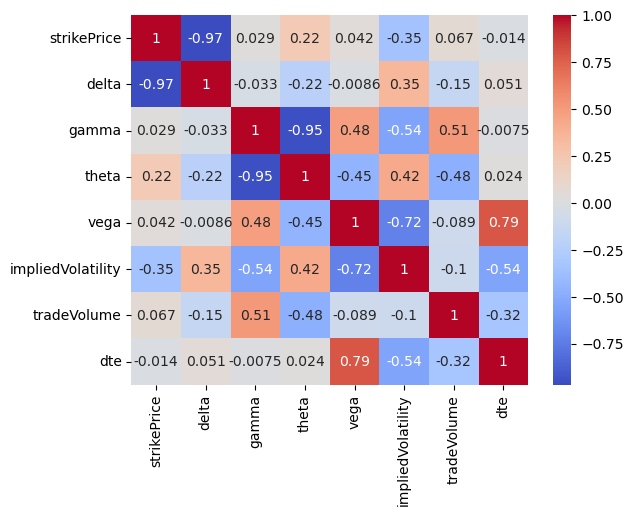

In [25]:
sns.heatmap(ce_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show();

### Bivariate Relationships

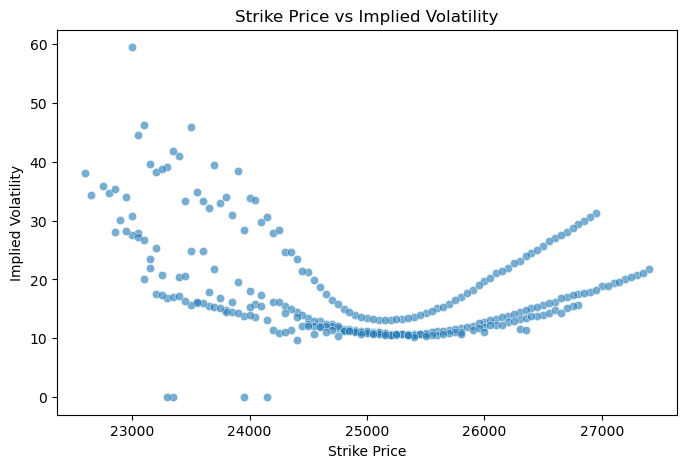

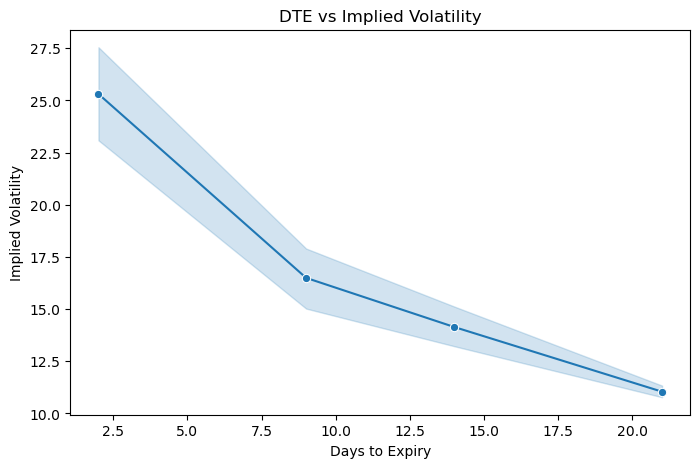

In [33]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="strikePrice", y="impliedVolatility", data=ce_df, alpha=0.6)
plt.title("Strike Price vs Implied Volatility")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.show();

plt.figure(figsize=(8, 5))
sns.lineplot(x="dte", y="impliedVolatility", data=ce_df, marker="o")
plt.title("DTE vs Implied Volatility")
plt.xlabel("Days to Expiry")
plt.ylabel("Implied Volatility")
plt.show();